In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy.linalg as la
import math
from sklearn.svm import SVR
from statsmodels.tsa.arima_model import ARIMA

In [2]:
def preprocess_data(data, time_len, rate, seq_len, pre_len):
    data1 = np.mat(data)
    train_size = int(time_len * rate)
    train_data = data1[0:train_size]
    test_data = data1[train_size:time_len]
    
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len):
        a = train_data[i: i + seq_len + pre_len]
        trainX.append(a[0 : seq_len])
        trainY.append(a[seq_len : seq_len + pre_len])
    for i in range(len(test_data) - seq_len -pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0 : seq_len])
        testY.append(b[seq_len : seq_len + pre_len])
    return trainX, trainY, testX, testY

In [3]:
def evaluation(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    F_norm = la.norm(a-b)/la.norm(a)
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a - b))/np.var(a)
    return rmse, mae, 1-F_norm, r2, var

In [4]:
path = r'ARIMA.csv'
data = pd.read_csv(path)

In [5]:
time_len = data.shape[0]
num_nodes = data.shape[1]

In [6]:
print(time_len)

1499


In [7]:
print(num_nodes)

2400


In [8]:
train_rate = 0.8
seq_len = 6
pre_len = 1
trainX,trainY,testX,testY = preprocess_data(data, time_len, train_rate, seq_len, pre_len)
total_rmse, total_mae, total_acc, result = [], [],[],[]
for i in range(num_nodes):
    data1 = np.mat(data)
    a = data1[:,i]
    a_X, a_Y, t_X, t_Y = preprocess_data(a, time_len, train_rate, seq_len, pre_len)
    a_X = np.array(a_X)
    a_X = np.reshape(a_X,[-1, seq_len])
    a_Y = np.array(a_Y)
    a_Y = np.reshape(a_Y,[-1, pre_len])
    a_Y = np.mean(a_Y, axis=1)
    t_X = np.array(t_X)
    t_X = np.reshape(t_X,[-1, seq_len])
    t_Y = np.array(t_Y)
    t_Y = np.reshape(t_Y,[-1, pre_len])    
       
    svr_model=SVR(kernel='rbf')
    svr_model.fit(a_X, a_Y)
    pre = svr_model.predict(t_X)
    pre = np.array(np.transpose(np.mat(pre)))
    pre = pre.repeat(pre_len ,axis=1)
    result.append(pre)
result1 = np.array(result)
result1 = np.reshape(result1, [num_nodes,-1])
result1 = np.transpose(result1)
testY1 = np.array(testY)


testY1 = np.reshape(testY1, [-1,num_nodes])
total = np.mat(total_acc)
total[total<0] = 0
rmse1, mae1, acc1,r2,var = evaluation(testY1, result1)
print('SVR_rmse:%r'%rmse1,
        'SVR_mae:%r'%mae1,
        'SVR_acc:%r'%acc1,
        'SVR_r2:%r'%r2,
        'SVR_var:%r'%var)

SVR_rmse:0.050507605048692734 SVR_mae:0.04385717317168552 SVR_acc:0.9070456675408487 SVR_r2:0.9627820843536294 SVR_var:0.9628790434626165


In [9]:
result1.shape

(293, 2400)

In [10]:
np.savetxt('prediction_svm.csv',result1,delimiter=',')

In [32]:
import torch
from torchvision import transforms
to_pil_image = transforms.ToPILImage()
data_prediction = torch.reshape(torch.tensor(result1[5,:],dtype = torch.float32),(1,40,60))
img = to_pil_image(data_prediction)

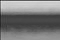

In [33]:
img

In [34]:
data_truth = torch.reshape(torch.tensor(testY1[5,:],dtype = torch.float32),(1,40,60))
img_truth = to_pil_image(data_truth)

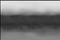

In [35]:
img_truth

In [36]:
from sklearn.metrics import mean_squared_error as MSE
MSE(testY1[5,:],result1[5,:])

0.002750039671600041

In [37]:
method = 'ARIMA'
def preprocess_data_arima(data, time_len, rate):
    data1 = np.mat(data)
    train_size = int(time_len * rate)
    train_data = data1[0:train_size]
    test_data = data1[train_size:time_len]
    return traain_data,test_data
prediction = []
truth = []
######## ARIMA #########
if method == 'ARIMA':
    rng = pd.date_range('1/1/2012', periods=1499, freq='D')
    a1 = pd.DatetimeIndex(rng)
    data.index = a1
    num = data.shape[1]   
    rmse,mae,acc,r2,var,pred,ori = [],[],[],[],[],[],[]
    for i in range(2400):
        ts = data.iloc[:,i]
        ts_log=np.log(ts)    
        ts_log=np.array(ts_log,dtype=np.float)
        where_are_inf = np.isinf(ts_log)
        ts_log[where_are_inf] = 0
        ts_log = pd.Series(ts_log)
        ts_log.index = a1
        model = ARIMA(ts_log,order=[1,0,0])
        properModel = model.fit()
        predict_ts = properModel.predict(1200, dynamic=True)
        log_recover = np.exp(predict_ts)
        ts = ts[log_recover.index]
        er_rmse,er_mae,er_acc,r2_score,var_score = evaluation(ts,log_recover)
        prediction.append(log_recover)
        truth.append(ts)
        rmse.append(er_rmse)
        mae.append(er_mae)
        acc.append(er_acc)
        r2.append(r2_score)
        var.append(var_score)
    acc1 = np.mat(acc)
    acc1[acc1 < 0] = 0
    print('arima_rmse:%r'%(np.mean(rmse)),
          'arima_mae:%r'%(np.mean(mae)),
          'arima_acc:%r'%(np.mean(acc1)),
          'arima_r2:%r'%(np.mean(r2)),
          'arima_var:%r'%(np.mean(var)))

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


arima_rmse:0.17694974040875555 arima_mae:0.1599552093740063 arima_acc:0.6735114495808311 arima_r2:-0.052570490797224485 arima_var:0.00021515119250021698


In [38]:
predict_ts

2015-04-15   -0.901892
2015-04-16   -0.814968
2015-04-17   -0.743664
2015-04-18   -0.685173
2015-04-19   -0.637192
                ...   
2016-02-03   -0.418161
2016-02-04   -0.418161
2016-02-05   -0.418161
2016-02-06   -0.418161
2016-02-07   -0.418161
Freq: D, Length: 299, dtype: float64

In [39]:
log_recover

2015-04-15    0.405801
2015-04-16    0.442653
2015-04-17    0.475369
2015-04-18    0.504003
2015-04-19    0.528775
                ...   
2016-02-03    0.658256
2016-02-04    0.658256
2016-02-05    0.658256
2016-02-06    0.658256
2016-02-07    0.658256
Freq: D, Length: 299, dtype: float64

In [40]:
ts

2015-04-15    0.337
2015-04-16    0.435
2015-04-17    0.576
2015-04-18    0.773
2015-04-19    0.859
              ...  
2016-02-03    0.945
2016-02-04    0.922
2016-02-05    0.882
2016-02-06    0.745
2016-02-07    0.541
Freq: D, Name: 3.37E-01.35, Length: 299, dtype: float64

In [62]:
prediction = np.array(prediction)
data_prediction = torch.reshape(torch.tensor(prediction[:,4],dtype = torch.float32),(1,40,60))
img = to_pil_image(data_prediction)

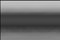

In [63]:
img

In [64]:
truth = np.array(truth)
data_prediction = torch.reshape(torch.tensor(truth[:,4],dtype = torch.float32),(1,40,60))
img_s = to_pil_image(data_prediction)

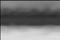

In [65]:
img_s

In [66]:
MSE(prediction[:,4],truth[:,4])

0.06077039173689738